<a href="https://colab.research.google.com/github/preetamjumech/autoencoder_from_scratch/blob/main/Preetam_Saha_23_09_2022_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#add some amount of noise , auto encoder will remove the noise
#pca, svd for dimensional reduction linear in nature
#in autoencoder, one encoder one decoding layer, in images, features are highly correlated, extract features which are non linear in nature
#to retain key features in input space, lesser no of dimension that is good thing,
#in training we are interested in encoder and decoder bothe, in inference  
#in inference either we are interested in encoder or interested in decoder, not both, (denoising the images - encoder and decoder both are required)

In [ ]:
!wget https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/training.pt
!wget https://github.com/MorvanZhou/PyTorch-Tutorial/raw/master/tutorial-contents-notebooks/mnist/processed/test.pt

In [ ]:
#first dnn based autoencoder, then we will create convolutional based autocoder
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [ ]:
train, test = torch.load("training.pt"), torch.load("test.pt")

In [ ]:
(x_train, y_train), (x_test,y_test) = (train, test)

In [ ]:
x_train = x_train.reshape(-1,28*28)/255.
x_test = x_test.reshape(-1,28*28)/255.

In [ ]:
encoder = nn.Sequential(nn.Linear(in_features = 28*28, out_features= 256), # if im using linear activation , will be similiar to pca, we will use non-linear here
                       nn.ReLU(),
                       nn.Linear(in_features=256,out_features=128),
                       nn.ReLU(),
                       nn.Linear(in_features=128,out_features=64),
                       nn.ReLU(),
                       nn.Linear(in_features=64,out_features=16)) #starting from 764, ending with 16, significant number of reduction of columns

In [ ]:
decoder = nn.Sequential(nn.Linear(in_features = 16, out_features= 64), 
                       nn.ReLU(),
                       nn.Linear(in_features=64,out_features=128),
                       nn.ReLU(),
                       nn.Linear(in_features=128,out_features=256),
                       nn.ReLU(),
                       nn.Linear(in_features=256,out_features=28*28)) #rate at which dimension was reduced , same rate to increase

In [ ]:
autoencoder = nn.Sequential(encoder,decoder) # we dont use batchnormalization, dropput in auto encoder, obj is to reach higher to lower dimension 

In [ ]:
#obj is to recreate the image, choice of loss function = RMSe, its a construction loss, we want to map this loss individual pixels.
train_loader = DataLoader(TensorDataset(x_train.float(),y_train),
                          batch_size=64,shuffle=True)
val_loader = DataLoader(TensorDataset(x_test.float(),y_test),
                          batch_size=64,shuffle=False)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

In [ ]:
epochs=50
autoencoder = autoencoder.to(device)
opt = Adam(autoencoder.parameters())

In [ ]:
#good practice to use a function instead of for loop
def train(model,train_loader,val_loader,opt,epoch):
  training_loss = 0.0
  val_loss = 0.0

#training portion
  for batch, _ in train_loader: #not building any classification model, so input = ouput
    batch = batch.to(device)
    target = batch.to(device)

    opt.zero_grad()
    train_output = model(batch)
    train_loss = F.mse_loss(train_output,target)
    train_loss.backward()
    opt.step()
    training_loss += train_loss.item()

  if (epoch+1) %  10 ==0:
    print(f"Train loss: {training_loss}")

#validation part
  with torch.no_grad():
    for val_batch, _ in val_loader:
      val_batch = val_batch.to(device)
      val_target = val_batch.to(device)
      
      val_output = model(val_batch)
      loss_val = F.mse_loss(val_output,val_target)
      val_loss += loss_val.item()

  
  if (epoch+1) %  10 ==0:
    print(f"Train loss: {training_loss} and Val loss: {val_loss}")

  return (training_loss, val_loss)

In [ ]:
losses = []
for epoch in range(epochs):
  losses.append(train(autoencoder,train_loader=train_loader, val_loader=val_loader,
                      opt=opt,epoch=epoch)) #epoch only for prininting, nothinh to do with training

Train loss: 13.785349544137716
Train loss: 13.785349544137716 and Val loss: 2.257694525644183
Train loss: 11.91914537269622
Train loss: 11.91914537269622 and Val loss: 1.9960096143186092
Train loss: 11.180045291781425
Train loss: 11.180045291781425 and Val loss: 1.8780414666980505
Train loss: 10.738649767823517
Train loss: 10.738649767823517 and Val loss: 1.8042737180367112
Train loss: 10.456409282051027
Train loss: 10.456409282051027 and Val loss: 1.785088049247861


In [ ]:
idx = 20
img_arbit = x_test[idx]

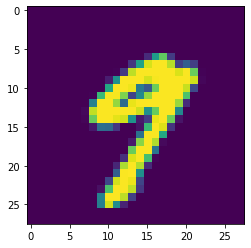

In [ ]:
plt.imshow(img_arbit.numpy().reshape(28,28))

In [ ]:
#here also kind of embeeding not exactly like text
input_data = img_arbit.reshape(1,-1).float().to(device)

In [ ]:
output_encoder = encoder(input_data)
output_encoder

tensor([[-1.0967,  1.4813,  0.4142,  0.3497, -0.1225,  0.6258,  0.8599, -0.5653,
         -0.8530, -0.0474, -0.2781,  0.6254,  0.2057,  0.1826,  0.0877,  0.7132]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
output_decoder=decoder(output_encoder).detach().cpu().numpy().reshape(28,28)

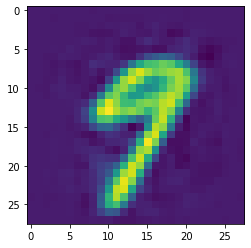

In [ ]:
plt.imshow(output_decoder)

In [ ]:
#this is vanila autoencoders  , another one is VAE